In [1]:
import subprocess
import os
import sys

import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

In [3]:
# paths
at_home = False if '/fast/work/users/' in os.getcwd() else True
data_path = '/extra/stefan/data/perturbation_resource_paper/' if at_home else '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'
signatures_path = '/home/peidli/utils/scrnaseq_signature_collection/' if at_home else '/fast/work/users/peidlis_c/utils/scrnaseq_signature_collection/'
utils_path = '/extra/stefan/utils/scrnaseq_utils/' if at_home else '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/'

# Stefan's utils
sys.path.insert(1, utils_path)
from scrnaseq_util_functions import *

In [4]:
name = 'ZhaoSims2021'
adata = read_from_singles(f'{data_path}{name}')

In [5]:
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.normalize_per_cell(adata)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.log1p(adata)

In [6]:
adata

AnnData object with n_obs × n_vars = 120250 × 26270
    obs: 'sample', 'GEO', 'Sample', 'tissue', 'age', 'sex', 'location', 'diagnosis', 'library', 'dose_value', 'dose_unit', 'perturbation', 'tissue_type', 'cancer', 'disease', 'celltype', 'organism', 'perturbation_type', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'n_counts'
    var: 'ncounts', 'ncells', 'n_cells'
    uns: 'log1p'

In [8]:
sc.pp.subsample(adata, n_obs=5000)

In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pp.pca(adata)
sc.pp.neighbors(adata)

In [10]:
sc.tl.umap(adata)

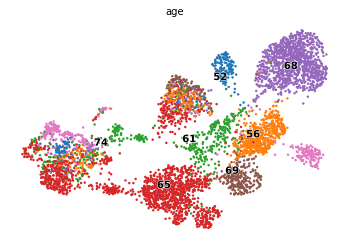

In [11]:
scv.pl.scatter(adata, color='age')

In [12]:
from vitessce import (
    VitessceConfig,
    Component as cm,
    CoordinationType as ct,
    AnnDataWrapper,
)

In [13]:
vc = VitessceConfig(name='Test', description='a test')

In [14]:
top_dispersion = adata.var["dispersions_norm"][
    sorted(
        range(len(adata.var["dispersions_norm"])),
        key=lambda k: adata.var["dispersions_norm"][k],
    )[-51:][0]
]
adata.var["top_highly_variable"] = (
    adata.var["dispersions_norm"] > top_dispersion
)

In [15]:
dataset = vc.add_dataset(name='TESTDATA').add_object(AnnDataWrapper(
        adata,
        mappings_obsm=["X_umap"],
        mappings_obsm_names=["UMAP"],
        cell_set_obs=['Sample', 'tissue', 'age', 'sex', 'perturbation', 'tissue_type'],
        #cell_set_obs_names=["Cell Type"],
        expression_matrix="X",
        matrix_gene_var_filter="top_highly_variable"
    )
)

In [16]:
scatterplot = vc.add_view(cm.SCATTERPLOT, dataset=dataset, mapping="UMAP")
cell_sets = vc.add_view(cm.CELL_SETS, dataset=dataset)
genes = vc.add_view(cm.GENES, dataset=dataset)
heatmap = vc.add_view(cm.HEATMAP, dataset=dataset)

In [17]:
vc.layout((scatterplot | cell_sets) / (heatmap | genes));

In [20]:
vw = vc.widget(proxy=True)
vw

[2022-04-22 12:15:57 +0200] [1590110] [INFO] Running on http://127.0.0.1:8001 (CTRL + C to quit)


VitessceWidget(config={'version': '1.0.4', 'name': 'Test', 'description': 'a test', 'datasets': [{'uid': 'A', …